In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [2]:
def recovery_dataset_id(X_y_group_train):
    # 假设'dataset'列是需要转换的列
    X_y_group_train['dataset'] = X_y_group_train['dataset'].apply(lambda x: f'{int(x):05}')
    return X_y_group_train

def clean_feature_names(X):
    # 函数用于清理特征名称
    def clean_name(name):
        # 移除或替换特殊字符
        name = re.sub(r'[^\w\s-]', '_', name)
        # 确保名称不以数字开头
        if name and name[0].isdigit():
            name = 'f_' + name
        return name

    X.columns = [clean_name(col) for col in X.columns]
    return X

def process_categorical_features(df, max_unique=10):
    """
    检测和处理数据框中的类别变量。

    参数：
    - df (pd.DataFrame): 输入的数据框。
    - max_unique (int): 判定为类别变量的最大唯一值数量。

    返回：
    - cat_idxs (list of int): 类别特征的索引。
    - cat_dims (list of int): 每个类别特征的模态数。
    - df (pd.DataFrame): 经过编码后的数据框。
    """
    cat_cols = [col for col in df.columns if df[col].nunique() <= max_unique]
    cat_dims = []
    cat_idxs = []

    for col in cat_cols:
        print(f"     处理类别特征: {col}，唯一值数量: {df[col].nunique()}")
        # 使用 LabelEncoder
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str).fillna('NaN'))
        cat_dims.append(len(le.classes_))
        cat_idxs.append(df.columns.get_loc(col))

    return cat_idxs, cat_dims, df

In [3]:
print("##### Reading data...")
# 读取数据
X_y_group_train = pd.read_csv('./mid_data/X_y_group_train_updated_v13.5_describe_v2.csv')
X_y_group_train = recovery_dataset_id(X_y_group_train)
print('     样本量', X_y_group_train.shape)

print("##### Adding numeric labels y")
# 添加数值标签 y
le = LabelEncoder()
X_y_group_train["y"] = le.fit_transform(X_y_group_train["label"])
# 重新排列列
X_y_group_train = X_y_group_train[["dataset", "variable"] + X_y_group_train.columns.drop(["dataset", "variable", "label", "y"]).tolist() + ["label", "y"]]

print("##### Data Preprocessing...")
# 定义要删除的列
blacklist = [
    "ttest(v,X)", 
    "pvalue(ttest(v,X))<=0.05", 
    "ttest(v,Y)", 
    "pvalue(ttest(v,Y))<=0.05", 
    "ttest(X,Y)", 
    "pvalue(ttest(X,Y))<=0.05",
    "square_dimension", 
    "max(PPS(v,others))",
    "TLI_Collider",
    "TLI_Confounder",
    "RMSEA_Collider",
    "RMSEA_Confounder",
]
columns_to_drop = [col for col in blacklist if col in X_y_group_train.columns]
X_y_group_train = X_y_group_train.drop(columns=columns_to_drop)
print('     删除多余列后样本量', X_y_group_train.shape)

# 处理数值列的缺失值
numeric_columns = X_y_group_train.select_dtypes(include=[np.number]).columns
X_y_group_train[numeric_columns] = X_y_group_train[numeric_columns].fillna(X_y_group_train[numeric_columns].mean())

# 清理特征名称
X_y_group_train = clean_feature_names(X_y_group_train)

print("##### Extracting X_train, y_train, and group")
# 分离数据集ID、特征和标签
group_train = X_y_group_train["dataset"]
X = X_y_group_train.drop(["variable", "dataset", "label", "y"], axis="columns")
y = X_y_group_train["y"]

# 处理类别特征
cat_idxs, cat_dims, X = process_categorical_features(X)
print(f"     类别特征索引 (cat_idxs): {cat_idxs}")
print(f"     类别特征模态数 (cat_dims): {cat_dims}")

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("     分割数据集后X_train & X_test shape:", X_train.shape, X_test.shape)
print("     y_train 唯一值:", np.unique(y_train))
print("     y_test 唯一值:", np.unique(y_test))

# 剔除离群样本
mask = (X_train['X_mean'] <= 0.1) & (X_train['Y_mean'] <= 0.1) & (X_train['variable_mean'] <= 0.1)
X_train = X_train[mask]
y_train = y_train[mask]
print("     剔除离群样本后X_train & X_test shape:", X_train.shape, X_test.shape)

# 定义要删除的列
blacklist = [
    "variable_mean",
    "variable_std",
    "X_mean",
    "Y_mean"
]
columns_to_drop = [col for col in blacklist if col in X_train.columns]
X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)
print("     删除多余列后X_train & X_test shape:", X_train.shape, X_test.shape)

# 计算类别权重（使用每个类别的逆频率）
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = list(class_weights)  # 转换为列表
print(f"     类别权重: {class_weights}")

##### Reading data...
样本量 (142910, 223)
##### Adding numeric labels y
##### Data Preprocessing...
删除多余列后样本量 (142910, 211)
##### Extracting X_train, y_train, and group
处理类别特征: dimension，唯一值数量: 8
处理类别特征: ExactSearch_v_X_，唯一值数量: 2
处理类别特征: ExactSearch_X_v_，唯一值数量: 2
处理类别特征: ExactSearch_v_Y_，唯一值数量: 2
处理类别特征: ExactSearch_Y_v_，唯一值数量: 2
处理类别特征: ExactSearch_X_Y_，唯一值数量: 2
处理类别特征: PC_v_X_，唯一值数量: 2
处理类别特征: PC_X_v_，唯一值数量: 2
处理类别特征: PC_v_Y_，唯一值数量: 2
处理类别特征: PC_Y_v_，唯一值数量: 2
处理类别特征: PC_X_Y_，唯一值数量: 2
处理类别特征: FCI_v_X_，唯一值数量: 4
处理类别特征: FCI_X_v_，唯一值数量: 4
处理类别特征: FCI_v_Y_，唯一值数量: 4
处理类别特征: FCI_Y_v_，唯一值数量: 4
处理类别特征: FCI_X_Y_，唯一值数量: 4
处理类别特征: GRaSP_v_X_，唯一值数量: 3
处理类别特征: GRaSP_X_v_，唯一值数量: 3
处理类别特征: GRaSP_v_Y_，唯一值数量: 3
处理类别特征: GRaSP_Y_v_，唯一值数量: 3
处理类别特征: GRaSP_X_Y_，唯一值数量: 3
类别特征索引 (cat_idxs): [0, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 137, 138, 139, 140, 141]
类别特征模态数 (cat_dims): [8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3]
分割数据集后X_train & X_test shape: (114328, 207) (2858

Best LGBM Pharamter now:
```python
model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=29,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    device='cpu',
    gpu_platform_id=1,
    gpu_device_id=0,
)
```

v12.1分数:0.6559
objective='multiclassova',
0.6567



In [4]:

model = LGBMClassifier(
    n_estimators=2000,            # 减少树的数量以防止过拟合
    learning_rate=0.05,           # 保持较低的学习率

    num_leaves=21,                # 减少叶子数量以控制复杂度
    max_depth=5,                  # 减小树的深度以简化模型

    min_child_samples=50,         # 增加叶子节点的最小样本数
    colsample_bytree=0.6,         # 减少特征采样比例

    reg_alpha=25.0,                # 增加L1正则化
    reg_lambda=25.0,               # 增加L2正则化
    
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    device='cpu',
)
display(model)

# 定义回调函数
callbacks = [lgb.log_evaluation(period=1), lgb.early_stopping(stopping_rounds=10)]

# 训练模型
model.fit(X_train, y_train, 
          callbacks=callbacks, 
          eval_set=[(X_test, y_test)],
          categorical_feature=cat_idxs)

# 预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 计算平衡准确率
train_score = balanced_accuracy_score(y_train, y_train_pred)
test_score = balanced_accuracy_score(y_test, y_test_pred)

print(f"Train balanced accuracy: {train_score:.6f}")
print(f"Test balanced accuracy: {test_score:.6f}")

# 输出详细的分类报告
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

LGBMClassifier(class_weight='balanced', colsample_bytree=0.6, device='cpu',
               learning_rate=0.05, max_depth=5, min_child_samples=50,
               n_estimators=2000, n_jobs=-1, num_leaves=21, random_state=42,
               reg_alpha=25.0, reg_lambda=25.0)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46493
[LightGBM] [Info] Number of data points in the train set: 114194, number of used features: 203
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079441
[LightGBM] [Info] Start training from score -2.079442
[1]	valid_0's multi_logloss: 1.96207
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mult

0.670



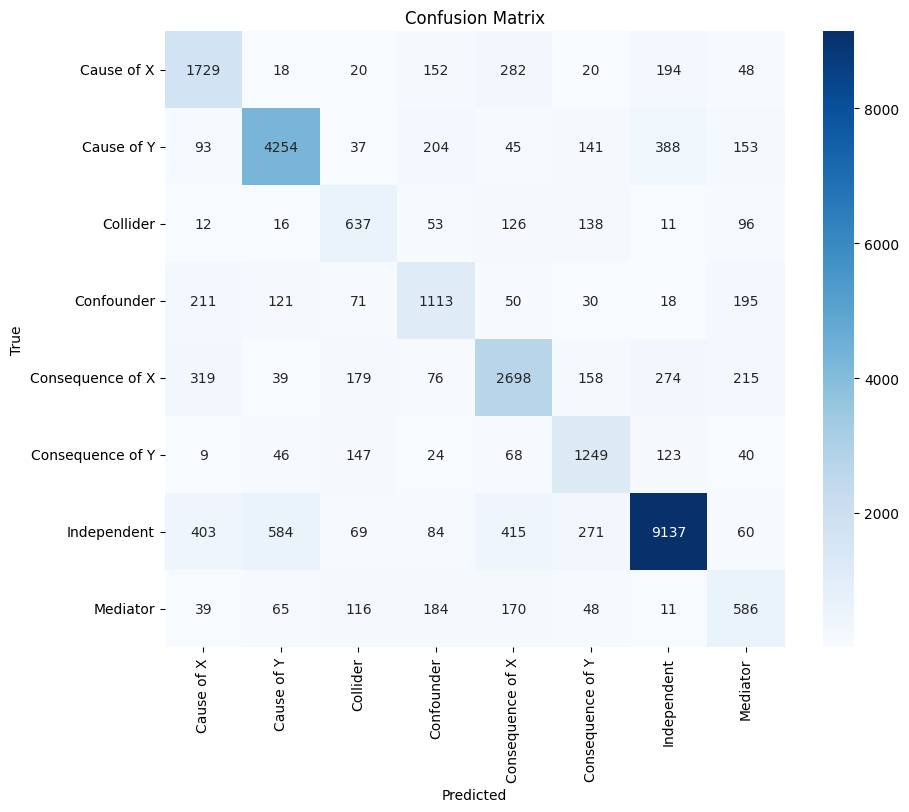

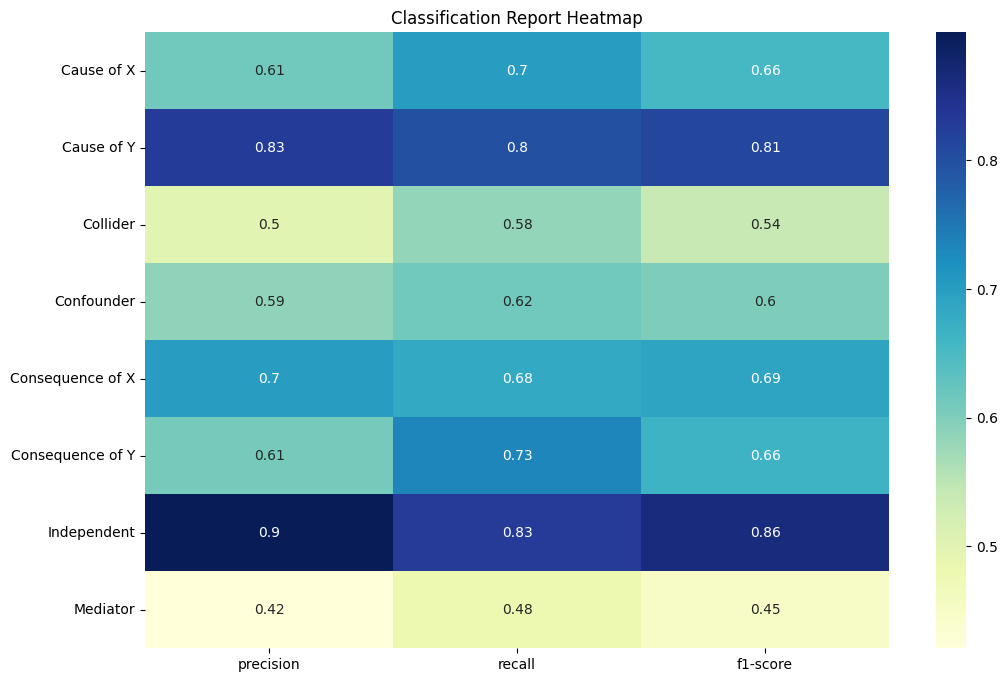

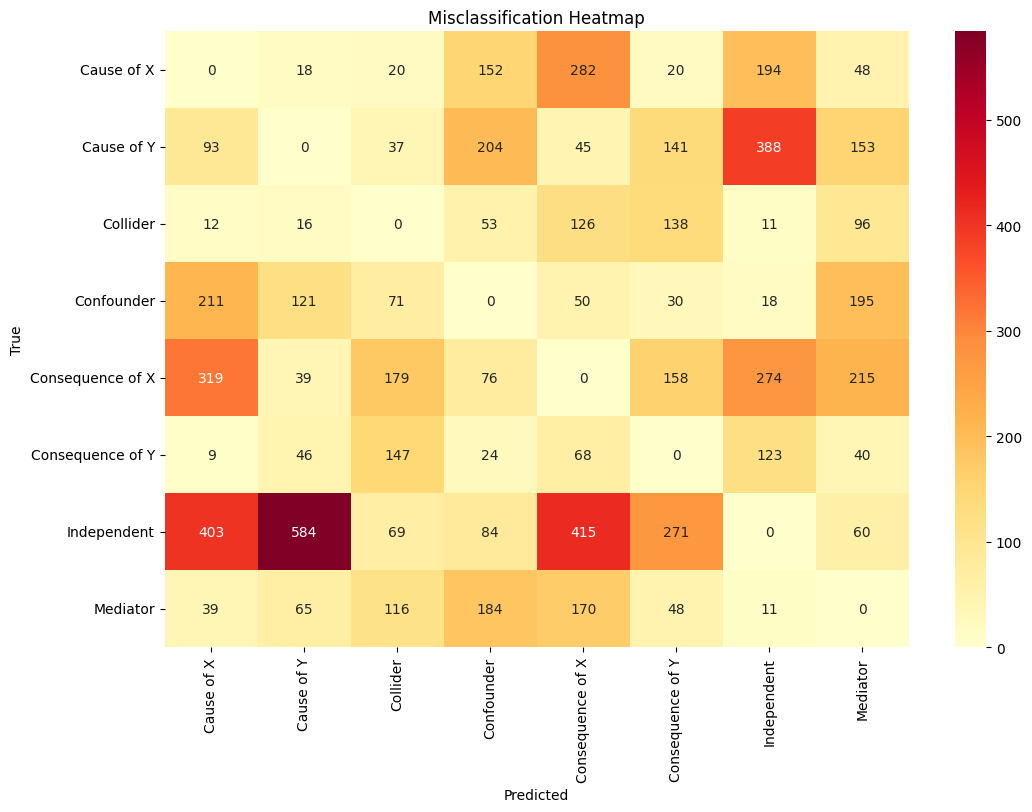

Most common misclassifications:
True              Predicted       
Independent       Cause of Y          584
                  Consequence of X    415
                  Cause of X          403
Cause of Y        Independent         388
Consequence of X  Cause of X          319
Cause of X        Consequence of X    282
Consequence of X  Independent         274
Independent       Consequence of Y    271
Consequence of X  Mediator            215
Confounder        Cause of X          211
dtype: int64


In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 假设我们已经有了预测结果 y_pred 和真实标签 y_true
# 如果没有,请先运行模型得到预测结果

# 1. 计算混淆矩阵

y_true = y_test
y_pred = y_test_pred

cm = confusion_matrix(y_true, y_pred)

# 2. 创建混淆矩阵热力图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 3. 计算每个类别的精确度、召回率和F1分数
report = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)

# 4. 创建分类报告可视化
df_report = pd.DataFrame(report).transpose()
plt.figure(figsize=(12, 8))
sns.heatmap(df_report.iloc[:-3, :-1].astype(float), annot=True, cmap='YlGnBu')
plt.title('Classification Report Heatmap')
plt.show()

# 5. 分析错误分类情况
misclassified = y_true != y_pred
error_df = pd.DataFrame({
    'True': le.inverse_transform(y_true[misclassified]),
    'Predicted': le.inverse_transform(y_pred[misclassified])
})
error_counts = error_df.groupby(['True', 'Predicted']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(error_counts, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Misclassification Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 打印最常见的错误分类情况
print("Most common misclassifications:")
print(error_df.groupby(['True', 'Predicted']).size().sort_values(ascending=False).head(10))


Case Study 1:
Dataset: 0, Variable: 5, Dimension: 8
True Label: Mediator, Predicted Label: Consequence of Y


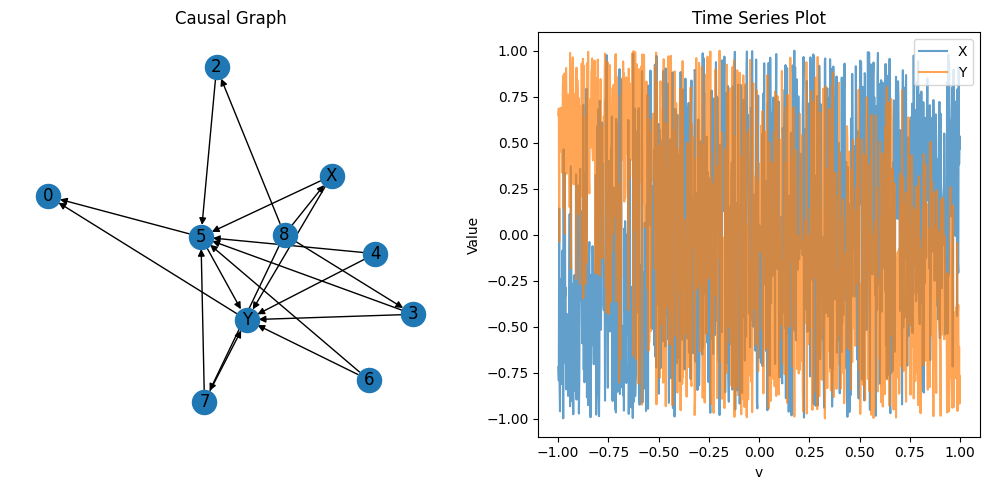

In [16]:
import networkx as nx

y_data_origin = pd.read_pickle('./data/y_train.pickle')
x_data_origin = pd.read_pickle('./data/x_train.pickle')

# 案例研究：错误分类样本分析
def case_study_misclassifications(X, y_true, y_pred, le, original_data, n_samples=5):
    misclassified = y_true != y_pred
    error_df = pd.DataFrame({
        'True': le.inverse_transform(y_true[misclassified]),
        'Predicted': le.inverse_transform(y_pred[misclassified])
    })
    
    # 添加原始数据的其他特征
    error_df = pd.concat([error_df, X[misclassified].reset_index(drop=True)], axis=1)
    error_df['dataset'] = original_data.loc[X[misclassified].index, 'dataset'].values
    error_df['variable'] = original_data.loc[X[misclassified].index, 'variable'].values
    error_df['dimension'] = original_data.loc[X[misclassified].index, 'dimension'].values
    
    # 按数据集和维度分组，并随机选择样本
    grouped = error_df.groupby(['dataset', 'dimension'])
    selected_samples = []
    
    for _, group in grouped:
        if len(selected_samples) < n_samples:
            selected_samples.append(group.sample(n=1))
    
    selected_df = pd.concat(selected_samples).reset_index(drop=True)
    
    # 对每个选中的样本进行分析
    for idx, row in selected_df.iterrows():
        print(f"\nCase Study {idx + 1}:")
        print(f"Dataset: {row['dataset']}, Variable: {row['variable']}, Dimension: {row['dimension']}")
        print(f"True Label: {row['True']}, Predicted Label: {row['Predicted']}")
        
        # 可视化该数据集的因果图
        dataset = row['dataset']
        dataset = str(dataset).zfill(5)
        
        full_graph_labels = y_data_origin[dataset]
        
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        visualize_causal_graph(full_graph_labels)
        plt.title("Causal Graph")
        
        # 绘制折线图
        plt.subplot(122)
        plot_time_series(x_data_origin[dataset], row['variable'])
        plt.title("Time Series Plot")
        
        plt.tight_layout()
        plt.show()
        
        # 显示重要特征
        # important_features = X.columns[np.argsort(model.feature_importances_)[-10:][::-1]]
        # feature_values = row[important_features]
        # print("\nTop 10 Important Features:")
        # print(feature_values)
        break


def visualize_causal_graph(labels):
    g = nx.DiGraph(labels)
    nx.draw(g, with_labels=True)
    
def plot_time_series(data, v):
    v_col = f"{v}"
    x_col = f"X"
    y_col = f"Y"
    
    data = data.sort_values(by=f'{v}', ascending=False)
    plt.plot(data[v_col], data[x_col], label='X', alpha=0.7)
    plt.plot(data[v_col], data[y_col], label='Y', alpha=0.7)
    plt.xlabel('v')
    plt.ylabel('Value')
    plt.legend()


# 运行案例研究
case_study_misclassifications(X_test, y_test, y_test_pred, le, X_y_group_train, n_samples=5)



                            feature  importance
44            v_X_ridge_coefficient        3699
107               Y_v_DML_std_point        3696
83                  Y_v_coefficient        3529
143             v_X_piecewise_coef4        3431
43            v_Y_ridge_coefficient        3419
..                              ...         ...
131               X_v_sliding_coef5         559
34   mean_spearman_corr_v_ others__         541
187                  TLI_Cause of X         541
173                  BIC_Cause of X         539
189            TLI_Consequence of X         534

[150 rows x 2 columns]


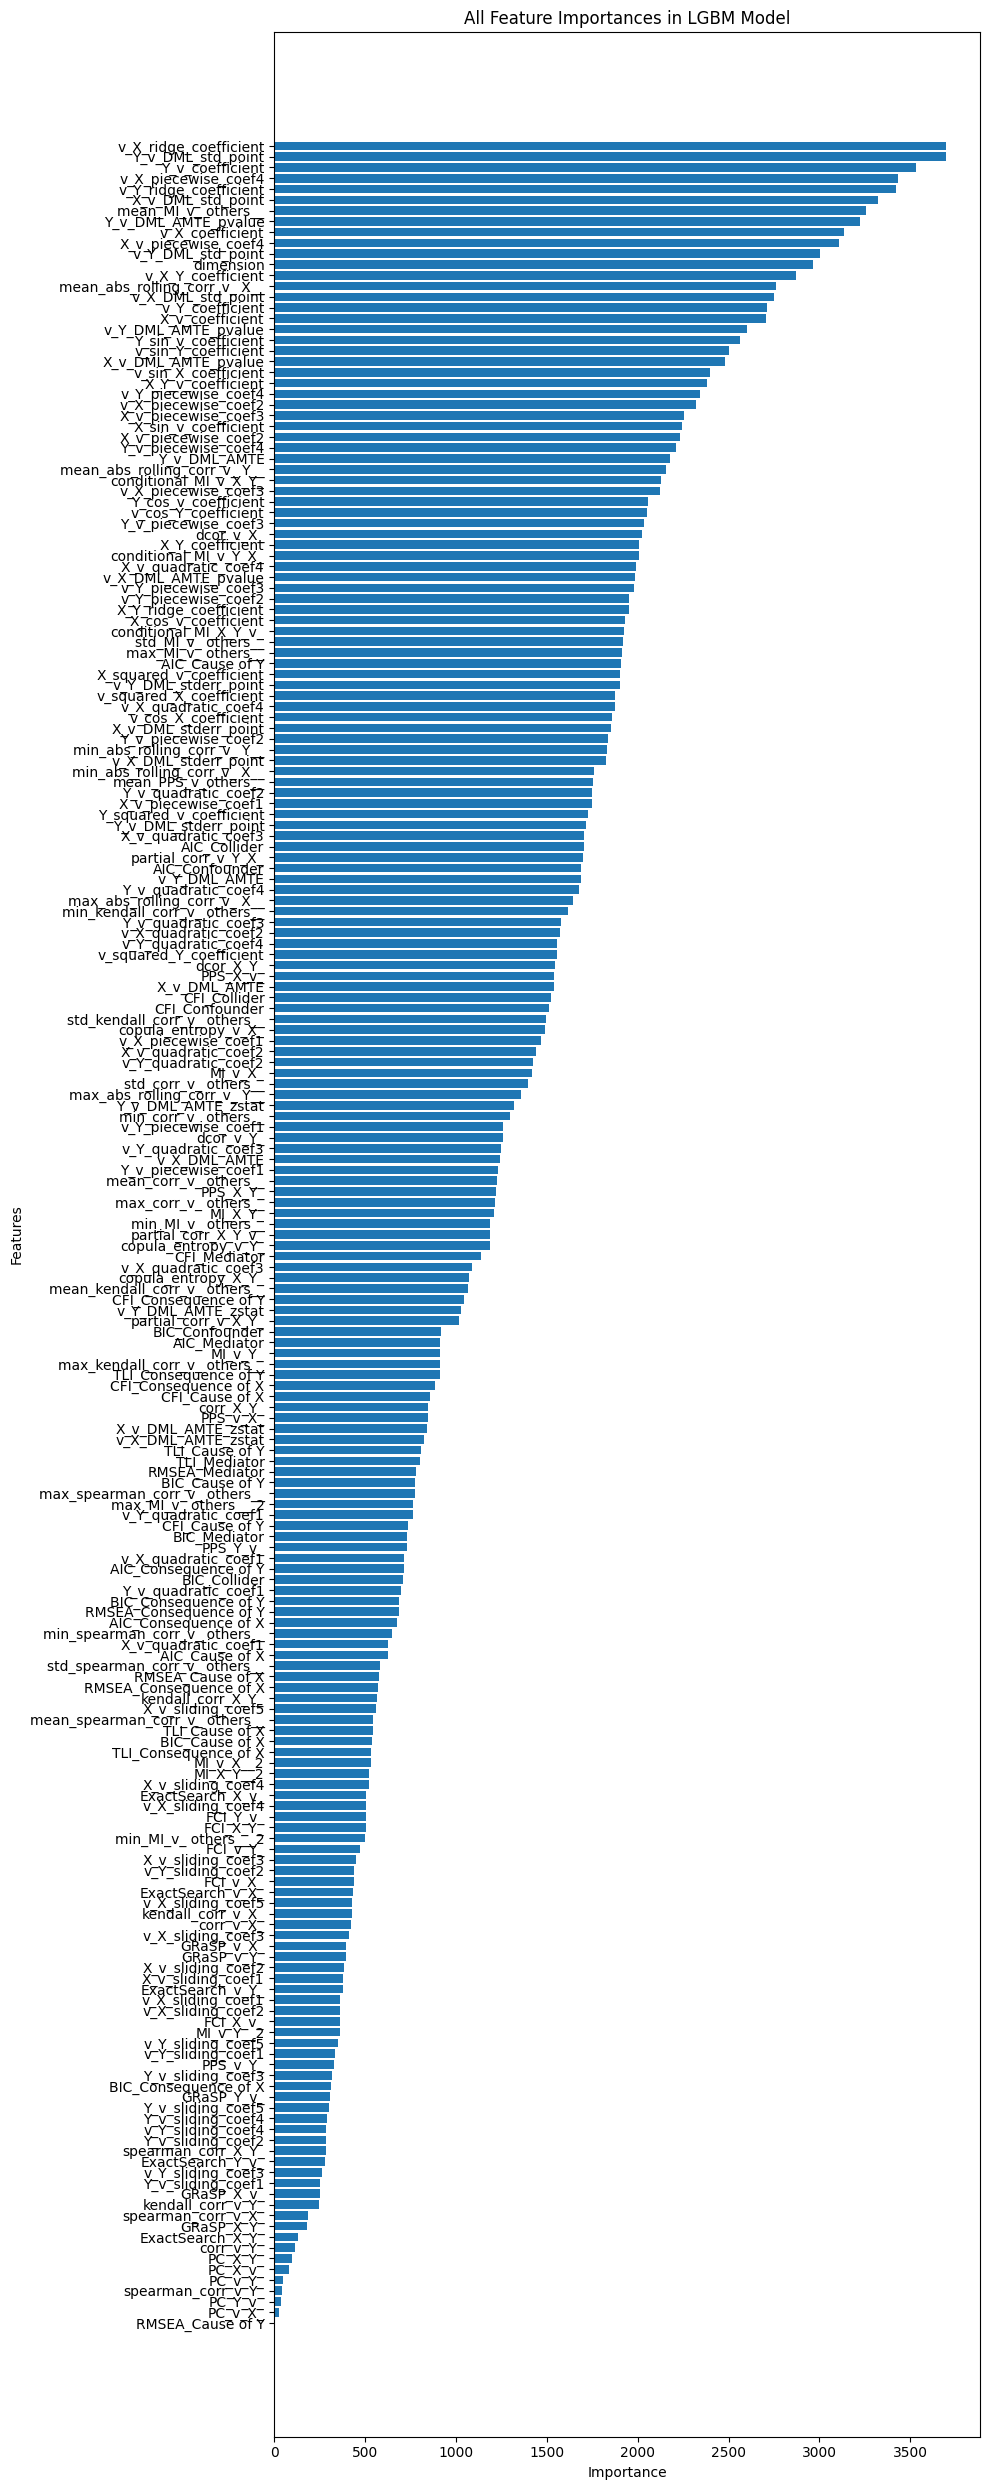

In [8]:
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create a dataframe of feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Display top 20 features
print(feature_importance_df.head(150))

# Optionally, you can plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 25))  # 调整图形大小，使其更高
plt.barh(feature_importance_df['feature'][:][::-1], feature_importance_df['importance'][:][::-1])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('All Feature Importances in LGBM Model')
plt.tight_layout()
plt.show()

In [26]:
print(feature_importance_df.head(150))

                 feature  importance
149  Xwv_piecewise_coef4        4614
145  vwX_piecewise_coef4        4566
85       Ywv_coefficient        4480
108  Ywv_DML_AMTE_pvalue        4250
98   vwY_DML_AMTE_pvalue        4229
..                   ...         ...
15    spearman_corravAXb         198
51      ExactSearchaXAYb         187
54               PCavAYb         151
55               PCaYAvb         141
52               PCavAXb         129

[150 rows x 2 columns]


In [49]:
feature_importance_df

,feature,importance
85,Ywv_coefficient,4335
145,vwX_piecewise_coef4,4190
149,Xwv_piecewise_coef4,4077
45,vwX_ridge_coefficient,4014
108,Ywv_DML_AMTE_pvalue,3970
...,...,...
15,spearman_corravAXb,149
52,PCavAXb,131
55,PCaYAvb,113
16,spearman_corravAYb,98
